In [1]:
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', 50)

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm_notebook
from catboost import CatBoostRegressor

from itertools import product
import sklearn
import scipy.sparse 
import lightgbm 

import warnings
warnings.filterwarnings("ignore")

# EDA

Import data

In [6]:
items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')
item_cats = pd.read_csv('data/item_categories.csv')
sales = pd.read_csv('data/sales_train_v2.csv')

test = pd.read_csv('data/test.csv', index_col=['ID'])
test['date_block_num'] = 34
all_data = pd.concat([sales, test], axis=0)

Let's check the target for outliners

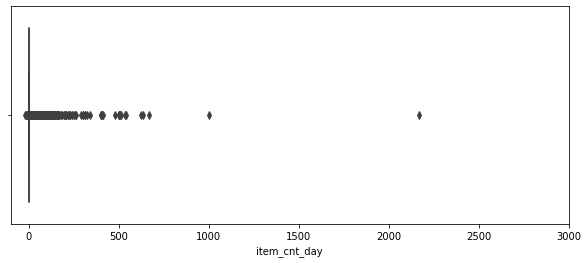

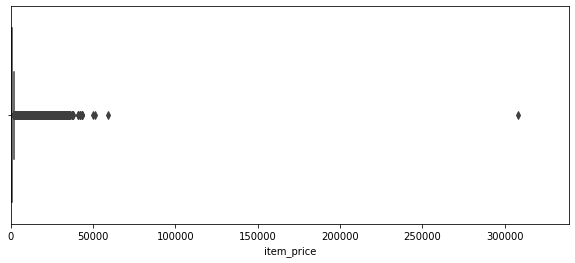

In [7]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.1)
sns.boxplot(x=sales.item_price);

We should remove outliners from train data

In [8]:
sales = sales[sales.item_cnt_day < 2000]
sales = sales[sales.item_price < 300000]

We have many position, where amount of sold items less then zero. This is the return of the items. We ill cast such positions to zero.

In [9]:
sales[sales.item_cnt_day < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.00,-1.0
148,23.01.2013,0,25,2321,999.00,-1.0
175,07.01.2013,0,25,2199,1449.00,-1.0
807,02.01.2013,0,25,2330,599.00,-1.0
1041,13.01.2013,0,25,5034,1989.00,-1.0
1193,02.01.2013,0,25,5651,5490.00,-1.0
1674,07.01.2013,0,25,4093,899.00,-1.0
1825,02.01.2013,0,25,4249,1894.87,-1.0
2411,14.01.2013,0,24,1628,3899.00,-1.0
3216,08.01.2013,0,24,20948,899.00,-1.0


But the price less then zero isn't normal. We will change it with median.

In [10]:
sales[sales.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [11]:
price_correction = all_data[(all_data['shop_id'] == 32) & (all_data['item_id'] == 2973) & (all_data['date_block_num'] == 4) & (all_data['item_price'] > 0)].item_price.median()
all_data.loc[all_data['item_price'] < 0, 'item_price'] = price_correction

Check shop names. There are several shops with different id's, but the same name

In [12]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [13]:
# Якутск Орджоникидзе, 56
all_data.loc[all_data.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
all_data.loc[all_data.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
all_data.loc[all_data.shop_id == 10, 'shop_id'] = 11

# Data prepare

Make time lags for shops and items

In [14]:
def make_lag(sales, items):
    # Create "grid" with columns
    index_cols = ['shop_id', 'item_id', 'date_block_num']

    # For every month we create a grid from all shops/items combinations from that month
    grid = [] 
    for block_num in sales['date_block_num'].unique():
        cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
        cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    # Turn the grid into a dataframe
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

    # Groupby data to get shop-item-month aggregates
    gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
    # Fix column names
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
    # Join it to the grid
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

    # Same as above but with shop-month aggregates
    gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # Same as above but with item-month aggregates
    gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

    # Downcast dtypes from 64 to 32 bit to save memory
    all_data = downcast_dtypes(all_data)
    del grid, gb 
    gc.collect();
    
    gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
    # List of columns that we will use to create lags
    cols_to_rename = list(all_data.columns.difference(index_cols)) 

    shift_range = [1, 2, 3, 4, 5, 12]

    for month_shift in tqdm_notebook(shift_range):
        train_shift = all_data[index_cols + cols_to_rename].copy()

        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)

        all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

        del train_shift

    # Don't use old data from year 2013
    all_data = all_data[all_data['date_block_num'] >= 12] 

    # List of all lagged features
    fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
    # We will drop these at fitting stage
    to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

    # Category for each item
    item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

    all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
    all_data = downcast_dtypes(all_data)
    gc.collect();
    return all_data

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [15]:
X = make_lag(all_data, items)

In [16]:
X.tail()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
6639289,45,18454,34,0.0,0.0,0.0,1.0,2.0,702.0,0.0,1.0,654.0,0.0,3.0,710.0,0.0,12.0,675.0,0.0,19.0,622.0,0.0,0.0,0.0,55
6639290,45,16188,34,0.0,0.0,0.0,0.0,1.0,702.0,0.0,3.0,654.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64
6639291,45,15757,34,0.0,0.0,0.0,0.0,5.0,702.0,0.0,3.0,654.0,0.0,4.0,710.0,0.0,4.0,675.0,0.0,8.0,622.0,0.0,9.0,1251.0,55
6639292,45,19648,34,0.0,0.0,0.0,0.0,2.0,702.0,0.0,3.0,654.0,0.0,7.0,710.0,0.0,2.0,675.0,0.0,4.0,622.0,0.0,0.0,0.0,40
6639293,45,969,34,0.0,0.0,0.0,0.0,3.0,702.0,0.0,5.0,654.0,0.0,1.0,710.0,0.0,2.0,675.0,0.0,2.0,622.0,0.0,6.0,1251.0,37


Add a flag to check, that this item has never been sold in this shop

In [17]:
X['neversold'] = X.groupby(['item_id', 'shop_id'])['target'].transform('size').map(lambda x: 1 if x<=1 else 0)

Now I want to add different features from shop names: city, feature that indicates, that this city is Moscow district, feature to check that this shop is distance shop.

In [18]:
shops['city'] = shops.shop_name.map(lambda x: x.split()[0])
shops['city'] = shops['city'].replace('!Якутск', 'Якутск')
shops['Moscow'] = shops.city.map(lambda x: 1 if x == 'Москва' else 0)
shops['MO'] = shops.city.map(lambda x: 1 if x in ['Чехов', 'Химки', 'Сергиев', 'Мытищи', 'Коломна', 'Жуковский', 'Балашиха'] else 0)
shops['distshop'] = shops.city.map(lambda x: 1 if x in ['Выездная', 'Интернет-магазин'] else 0)
shops['city'] = shops.city.map(lambda x: 'unknown' if x in ['Выездная', 'Интернет-магазин'] else x)
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops.drop(['shop_name', 'city'], axis=1)

Then we will create features on category information: subcategory and subcategory 2. There are many common words in this categories.

In [19]:
item_cats['subcat1'] = item_cats['item_category_name'].map(lambda x: x.split(' - ')[0])
item_cats['subcat1'] = LabelEncoder().fit_transform(item_cats['subcat1'])
item_cats['subcat2'] = item_cats['item_category_name'].map(lambda x: x.split(' - ')[-1])
item_cats['subcat2'] = LabelEncoder().fit_transform(item_cats['subcat2'])
item_cats = item_cats.drop('item_category_name', axis = 1)

In [20]:
X = pd.merge(X, item_cats, on=['item_category_id'], how='left')
X = pd.merge(X, shops, on=['shop_id'], how='left')

Add mead encoder features

In [21]:
cumsum1 = X.groupby('item_id')['target'].cumsum() - X['target']
cumcnt1 = X.groupby('item_id')['target'].cumcount()
encoded_feature = cumsum1/cumcnt1
encoded_feature.fillna(0.3343, inplace=True) 
X['mean_enc_item'] = encoded_feature

del cumsum1, cumcnt1
gc;

Add several simple features

In [22]:
X['month'] = X['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
X['days'] = X['month'].map(days).astype(np.int8)


We don't know prices for items in test data, so lets use median for all items. For items which wasn't reperesented in train data we will use mean price for category

In [23]:
item_price = all_data[all_data.date_block_num < 34].groupby('item_id')['item_price'].median()
X = pd.merge(X, item_price, how='left', on='item_id')
X['item_price'] = X.groupby("item_category_id")['item_price'].transform(lambda x: x.fillna(x.mean()))

But there is one category, about which we know nothing. This is category id - 0. Let's discover it

In [24]:
X[X.item_price.isnull()].item_category_id.value_counts()

0    42
Name: item_category_id, dtype: int64

In [25]:
item_cats[item_cats.item_category_id == 0]

,item_category_id,subcat1,subcat2
0,0,0,31


We have no common category, but we can find all items headphones and take their price

In [26]:
nau_id = items[items.item_name.map(str.lower).str.contains('наушники')]['item_id']

X = X.fillna(X[(X.item_price.notnull())&(X.item_id.isin(nau_id))]['item_price'].median())

Binary features for prices

In [27]:
X['low_low_price'] = (X['item_price'] < 100).astype('int8')
X['low_price'] = ((X['item_price'] >= 100)& (X['item_price'] < 300)).astype('int8')
X['medium_price'] = ((X['item_price'] >= 300)& (X['item_price'] < 500)).astype('int8')
X['high_price'] = ((X['item_price'] >= 500)& (X['item_price'] < 850)).astype('int8')
X['very_high_price'] = (X['item_price'] >= 850).astype('int8')

In [28]:
X.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id,neversold,subcat1,subcat2,Moscow,MO,distshop,city_code,mean_enc_item,month,days,item_price,low_low_price,low_price,medium_price,high_price,very_high_price
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,0,11,1,0,1,0,25,0.3343,0,31,749.0,0,0,0,1,0
1,54,10296,12,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38,0,11,2,0,1,0,25,0.3343,0,31,1599.0,0,0,0,0,1
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,0,11,6,0,1,0,25,0.3343,0,31,169.0,0,1,0,0,0
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,0,11,1,0,1,0,25,0.3343,0,31,699.0,0,0,0,1,0
4,54,10284,12,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57,0,13,10,0,1,0,25,0.3343,0,31,299.0,0,1,0,0,0


# Models

## Model 1 - lightgbm

In [29]:
def train_test_modern(all_data):
    y_train = all_data[(all_data.date_block_num >= 12)&(all_data.date_block_num < 33)]\
        .set_index(['shop_id', 'item_id', 'date_block_num'])['target'].clip(0,20)
    y_valid = all_data[all_data.date_block_num == 33]\
        .set_index(['shop_id', 'item_id', 'date_block_num'])['target'].clip(0,20)
    all_data = all_data.drop(['target','target_shop','target_item'], axis=1)
    X_train = all_data[(all_data.date_block_num >= 12)&(all_data.date_block_num < 33)]\
        .set_index(['shop_id', 'item_id', 'date_block_num']).copy()
    X_valid = all_data[all_data.date_block_num == 33]\
        .set_index(['shop_id', 'item_id', 'date_block_num']).copy()
    X_test = all_data[all_data.date_block_num == 34]\
        .set_index(['shop_id', 'item_id', 'date_block_num']).copy()
    return X_train, X_valid, y_train, y_valid, X_test

In [30]:
def lgb_train(X_train, X_test, y_train, y_test, categorical_features, params):
    lgtrain = lightgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    lgvalid = lightgbm.Dataset(X_test, y_test,categorical_feature=categorical_features)
    model = lightgbm.train(params, lgtrain, 4000, valid_sets=[lgvalid], early_stopping_rounds=400, verbose_eval=200)
    pred_test = model.predict(X_test, num_iteration=model.best_iteration)
    return model, pred_test

In [31]:
categorical_features = ['item_category_id', 'month', 'subcat1', 'subcat2', 'city_code']

In [32]:
X_train, X_valid, y_train, y_valid, X_test = train_test_modern(X)

In [33]:
params = {
    "objective" : "regression",
    'max_depth' : 8,
    "metric" : "rmse", 
    "num_threads" : -1,
    "learning_rate" : 0.05,
    'bagging_fraction': 0.8,
    "verbosity" : -1
    }

In [34]:
model, pred_valid_lgb = lgb_train(X_train, X_valid, y_train, y_valid, categorical_features, params)

Training until validation scores don't improve for 400 rounds
[200]	valid_0's rmse: 0.852181
[400]	valid_0's rmse: 0.847878
[600]	valid_0's rmse: 0.843785
[800]	valid_0's rmse: 0.84214
[1000]	valid_0's rmse: 0.841007
[1200]	valid_0's rmse: 0.840162
[1400]	valid_0's rmse: 0.840866
Early stopping, best iteration is:
[1164]	valid_0's rmse: 0.840051


In [35]:
np.sqrt(mean_squared_error(y_valid, pred_valid_lgb))

0.840051257126671

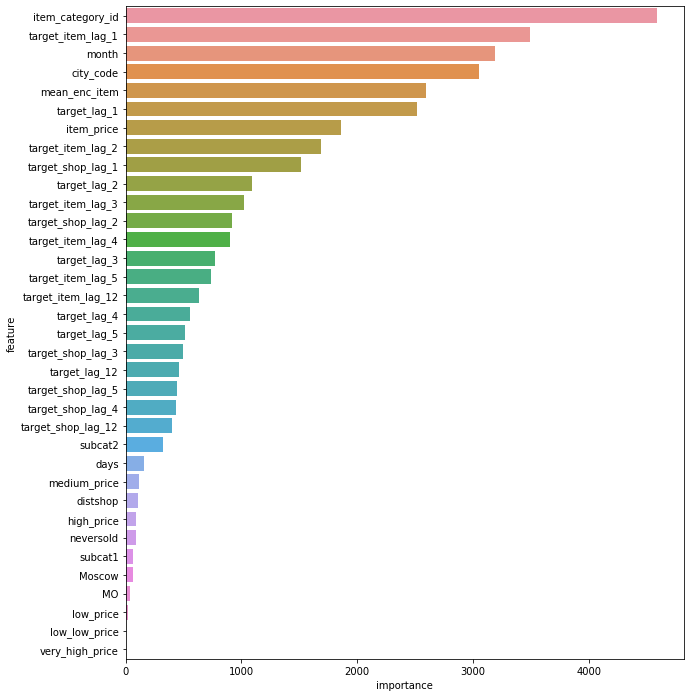

In [36]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':model.feature_importance()}).sort_values('importance', ascending=False)[:100]

plt.figure(figsize=(10,12))
sns.barplot(x=feature_importance.importance, y=feature_importance.feature);

In [37]:
pred_test_lgb = model.predict(X_test, num_iteration=model.best_iteration )

## Model 2 - Catboost

In [38]:
def cat_train(X_train, X_test, y_train, y_test, categorical_features, params):
    model = CatBoostRegressor(**(params))
    model.fit(X_train, 
        y_train.astype(int), 
        eval_set=(X_test, y_test.astype(int)), 
        cat_features=categorical_features, 
        use_best_model=True, 
        verbose=200)

    pred = model.predict(X_test)
    return model, pred

In [39]:
params_cat =  {'iterations': 1000,
    'random_seed': 63,
    'learning_rate': 0.05,
    'eval_metric': 'RMSE',
    'bagging_temperature': 0.2,
    'early_stopping_rounds': 200,
    'leaf_estimation_method': 'Newton'}

In [40]:
model_cat, pred_valid_cat = cat_train(X_train, X_valid, y_train, y_valid, categorical_features, params_cat)

0:	learn: 1.1632832	test: 1.1169114	best: 1.1169114 (0)	total: 5.03s	remaining: 1h 23m 40s
200:	learn: 0.7811130	test: 0.8685428	best: 0.8685428 (200)	total: 15m 32s	remaining: 1h 1m 47s
400:	learn: 0.7592372	test: 0.8546172	best: 0.8546172 (400)	total: 30m 26s	remaining: 45m 27s
600:	learn: 0.7467950	test: 0.8458961	best: 0.8458961 (600)	total: 45m 9s	remaining: 29m 58s
800:	learn: 0.7372801	test: 0.8418877	best: 0.8418189 (796)	total: 59m 47s	remaining: 14m 51s
999:	learn: 0.7306023	test: 0.8392316	best: 0.8391918 (994)	total: 1h 14m 43s	remaining: 0us

bestTest = 0.8391918268
bestIteration = 994

Shrink model to first 995 iterations.


In [41]:
np.sqrt(mean_squared_error(y_valid, pred_valid_cat))

0.8391918268304113

In [42]:
pred_test_cat = model_cat.predict(X_test)

## Model 2 - Liner Regression

In [43]:
columns_to_scale = ['target_lag_1', 'target_item_lag_1', 'target_shop_lag_1',
       'target_lag_2', 'target_item_lag_2', 'target_shop_lag_2',
       'target_lag_3', 'target_item_lag_3', 'target_shop_lag_3',
       'target_lag_4', 'target_item_lag_4', 'target_shop_lag_4',
       'target_lag_5', 'target_item_lag_5', 'target_shop_lag_5',
       'target_lag_12', 'target_item_lag_12', 'target_shop_lag_12', 'mean_enc_item', 'item_price']

In [44]:
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train[columns_to_scale])
X_valid_lr = scaler.transform(X_valid[columns_to_scale])
X_test_lr = scaler.transform(X_test[columns_to_scale])

In [45]:
lr = LinearRegression()
lr.fit(X_train_lr, y_train)
pred_valid_lr = lr.predict(X_valid_lr)

In [46]:
np.sqrt(mean_squared_error(y_valid, pred_valid_lr))

0.9979754058891913

In [47]:
pred_test_lr = lr.predict(X_test_lr)

## Model3 - KNN Regressor

In [48]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(X_train_lr[-30000:], y_train[-30000:])
pred_valid_knn = knn_model.predict(X_valid_lr)

In [49]:
np.sqrt(mean_squared_error(y_valid, pred_valid_knn))

0.9479315

In [50]:
pred_test_knn = knn_model.predict(X_test_lr)

## Ensembling

Now we should create table from the predictions of all models

In [51]:
train_new = pd.DataFrame(index=X_valid.index)
train_new['lgb'] = pred_valid_lgb
train_new['catboost'] = pred_valid_cat
train_new['lr'] = pred_valid_lr
train_new['knn'] = pred_valid_knn

Fit meta model

In [52]:
lr_meta = LinearRegression()
lr_meta.fit(train_new, y_valid)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
test_new = pd.DataFrame(index=X_test.index)
test_new['lgb'] = pred_test_lgb
test_new['catboost'] = pred_test_cat
test_new['lr'] = pred_test_lr
test_new['knn'] = pred_test_knn

Make final prediction

In [54]:
result = lr_meta.predict(test_new)

Create submission

In [55]:
def submis_write(res, filename='sub.csv'):
    submis = pd.DataFrame({'ID': test.index, 'item_cnt_month': res})
    submis.to_csv(filename, index=False)

In [56]:
submis_write(result)